**Промышленность — задача проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## План работы:  
- Провести преобработку данных с  исследовательским анализом данных:
    - Загрузить данные
    - Посмотреть на распределение исходных данных
    - Проанализировать порядок событий в производственном процессе
    - Исключить партии, которые не имеют последнего замера темпиратуры, либо первый замер соответствует последнему, либо замеры отсутствуют 
    - Оставить только события, которые находятся в промежутке между первым и последним замерами
    - Подобрать признаки, на которых будет обучаться модель:
    - Сгенерировать ряд признаков
    - Провести масштабирование признаков (если понадобиться)
- Построить модель, которая предскажет температуру стали:
    - Сформировать обучающую и тестовую выборки
    - Выбрать несколько моделей и проверить их эффективность с помощью показателя эффективности MAE
    - Эффективность лучшей модели проверить на тестовой выборке
- Вывод
- Отчет о проделанной работе 
    

## Предобработка данных с исследовательским анализом данных

###  Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import matplotlib.pyplot as plt
import math



sns.set_style("darkgrid")
import scipy.stats as sps
import math
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import os
import time
import itertools
import urllib.request
from scipy import stats
from pathlib import Path
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [2]:
warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 290822

In [4]:
df_arc=pd.read_csv('/datasets/final_steel/data_arc.csv')
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
df_bulk=pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [6]:
df_gas=pd.read_csv('/datasets/final_steel/data_gas.csv')
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [7]:
df_temp=pd.read_csv('/datasets/final_steel/data_temp.csv')
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [8]:
df_wire=pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_bulk_time=pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [10]:
df_wire_time=pd.read_csv('/datasets/final_steel/data_wire_time.csv')
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Данные об электродах

In [11]:
def fun_date(data):
    print('Общая информация')
    display(data.info())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Cтатистическиe данные')
    display(data.describe())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Вывод рандомных строк')
    display(data.sample(n=3, random_state=1))
    print('-------------------------------------------------------------------------------------------------------------')
    print('Количества дубликатов')
    display(data.duplicated().sum())
    print('-------------------------------------------------------------------------------------------------------------')
    print('Количества пропущеных значений')
    display(data.isna().sum())
    print('-------------------------------------------------------------------------------------------------------------')
print(fun_date(df_arc))

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


-------------------------------------------------------------------------------------------------------------
Вывод рандомных строк


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9491,2059,2019-07-21 19:50:16,2019-07-21 19:52:10,0.393992,0.238762
8654,1883,2019-07-09 09:40:20,2019-07-09 09:41:58,0.325188,0.255067
5244,1138,2019-06-13 20:21:19,2019-06-13 20:23:30,0.561328,0.399679


-------------------------------------------------------------------------------------------------------------
Количества дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количества пропущеных значений


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

-------------------------------------------------------------------------------------------------------------
None


In [12]:
df_arc['Начало нагрева дугой'] = pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
df_arc['Конец нагрева дугой'] = pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')

Приведем данные к нужному виду

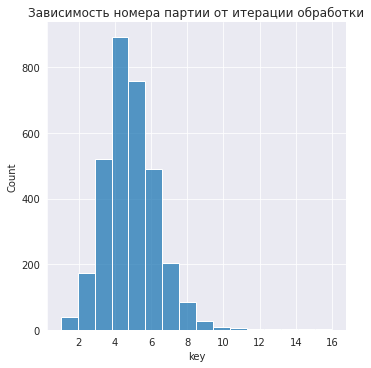

In [13]:
fig = sns.displot(df_arc['key'].value_counts(),bins=16)
plt.title('Зависимость номера партии от итерации обработки')
plt.show()

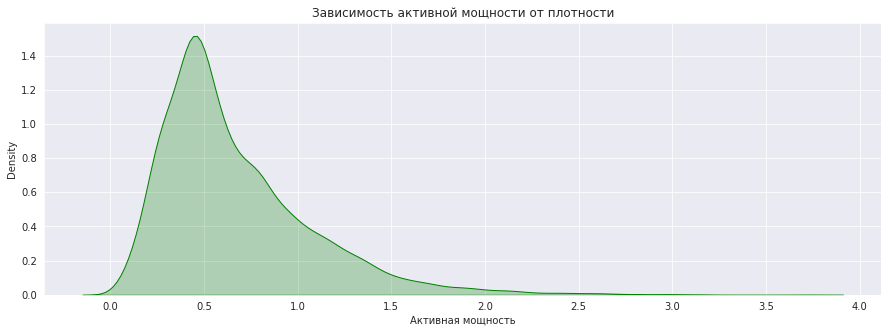

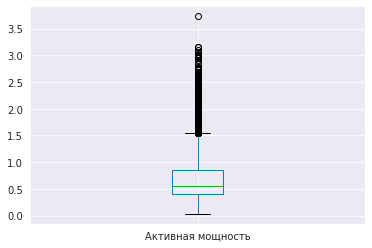

In [14]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Активная мощность'],color='g', legend=True,shade=True)
plt.title('Зависимость активной мощности от плотности')
plt.show()
fig2 =df_arc.boxplot('Активная мощность')
plt.show()

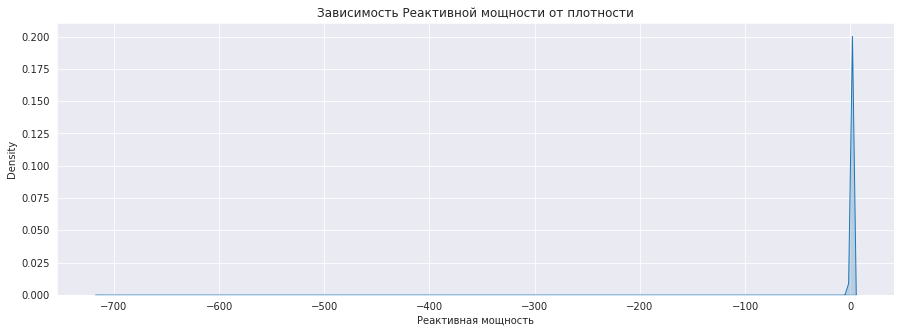

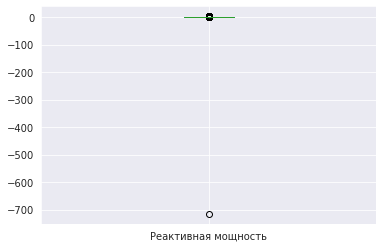

In [15]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Реактивная мощность'], legend=True,shade=True)
plt.title('Зависимость Реактивной мощности от плотности')
plt.show()
fig2 =df_arc.boxplot('Реактивная мощность')
plt.show()

уберем аномалии в данных

In [16]:
df_arc =df_arc[df_arc['Реактивная мощность'] >= 0]

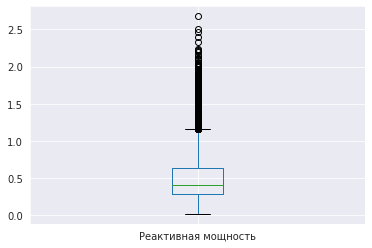

In [17]:
fig2 =df_arc.boxplot('Реактивная мощность')
plt.show()

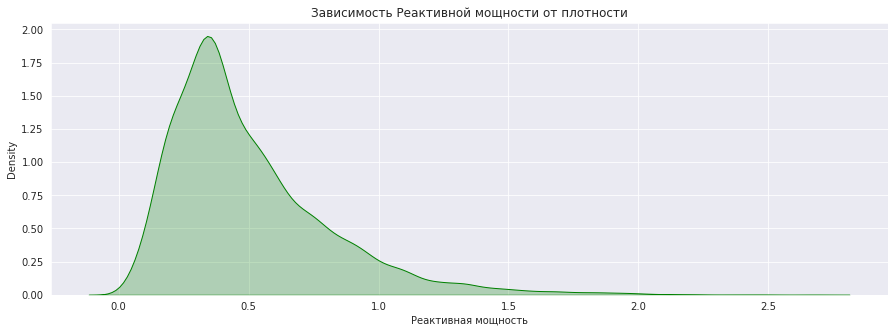

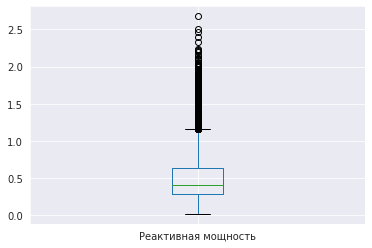

In [18]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Реактивная мощность'], color='g',legend=True,shade=True)
plt.title('Зависимость Реактивной мощности от плотности')
plt.show()
fig2 =df_arc.boxplot('Реактивная мощность')
plt.show()

Корреляция Активной и Реактивной мощности

In [19]:
print('Корреляция Активной и Реактивной мощности', df_arc['Активная мощность'].corr(df_arc['Реактивная мощность']))

Корреляция Активной и Реактивной мощности 0.9631819131519804


Корреляция между активом и реактивом почти  равна единицы: модель может переобучиться, можно использовать полную мощность

In [20]:
def full_power(row):
        
    full_power= math.sqrt(row['Активная мощность']**2 + row['Реактивная мощность']**2)
    return full_power

Расчитали полную мощность 

In [21]:
df_arc['Полная мощность'] = df_arc.apply(full_power, axis=1)

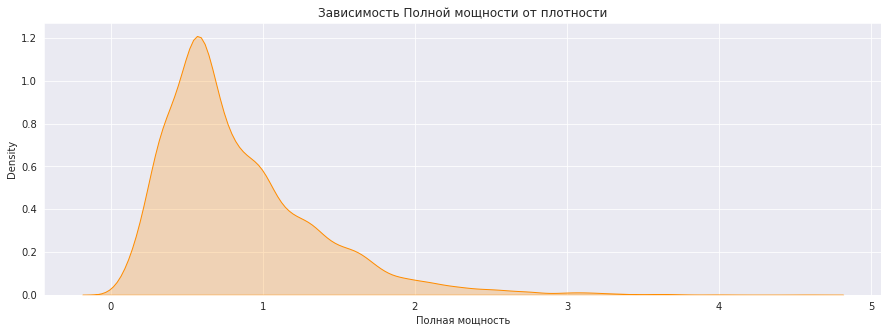

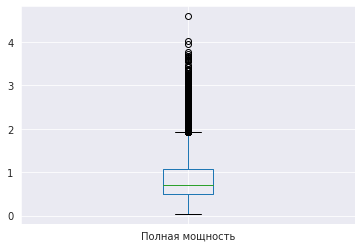

In [22]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_arc['Полная мощность'], color='darkorange',legend=True,shade=True)
plt.title('Зависимость Полной мощности от плотности')
plt.show()
fig2 =df_arc.boxplot('Полная мощность')

Данные приведены к нужному типу. Убрали аномалии в реактивной мощности.
Произведен расчет значения полной мощности. 

### Данные о подаче сыпучих материалов (объём)

In [23]:
fun_date(df_bulk)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


-------------------------------------------------------------------------------------------------------------
Вывод рандомных строк


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3113,3226,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN,68.0,204.0,NaN,150.0,206.0
110,123,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,255.0,NaN
2404,2496,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0


-------------------------------------------------------------------------------------------------------------
Количества дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количества пропущеных значений


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

-------------------------------------------------------------------------------------------------------------


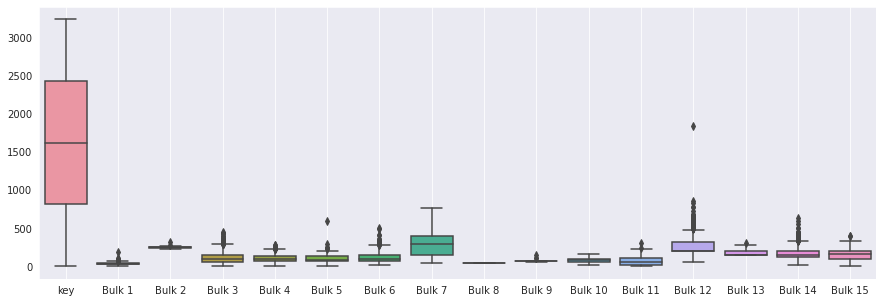

In [24]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_bulk)
plt.grid();

Единичное значение объема материала под номером 12 похож на выброс, на данном этапе оставим значение без изменения.

Типы данных в порядке, дубликатов нет Имеются пропуcки

### Данные о продувке сплава газом

In [25]:
fun_date(df_gas)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-------------------------------------------------------------------------------------------------------------
Вывод рандомных строк


,key,Газ 1
2161,2164,10.021713
1603,1606,11.502420
2248,2251,10.177622


-------------------------------------------------------------------------------------------------------------
Количества дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количества пропущеных значений


key      0
Газ 1    0
dtype: int64

-------------------------------------------------------------------------------------------------------------


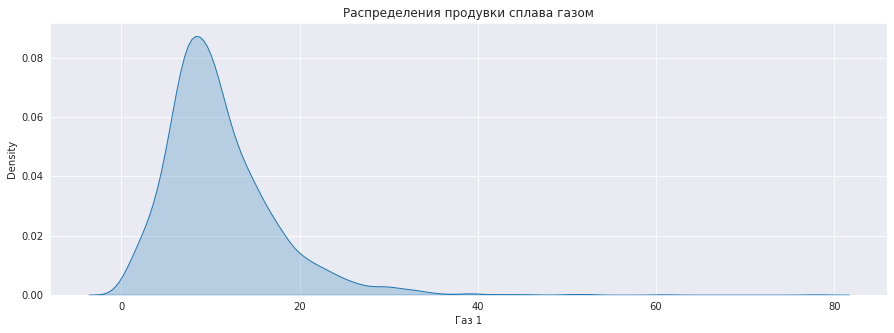

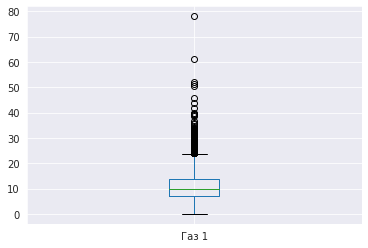

In [26]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_gas['Газ 1'], legend=True,shade=True)
plt.title('Распределения продувки сплава газом')
plt.show()
fig2 =df_gas.boxplot('Газ 1')


Данные в порядке.

### Результаты измерения температуры

In [27]:
fun_date(df_temp)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


-------------------------------------------------------------------------------------------------------------
Вывод рандомных строк


,key,Время замера,Температура
9251,1883,2019-07-09 09:52:03,1604.0
8217,1673,2019-07-02 02:30:35,1582.0
15422,3135,2019-08-28 16:50:17,NaN


-------------------------------------------------------------------------------------------------------------
Количества дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количества пропущеных значений


key                0
Время замера       0
Температура     2901
dtype: int64

-------------------------------------------------------------------------------------------------------------


In [28]:
df_temp['Время замера'] = pd.to_datetime(df_temp['Время замера'], format='%Y-%m-%dT%H:%M:%S')

Привели тип данных в нужный формат

In [29]:
df_temp.dropna().reset_index(drop = True)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
13001,3237,2019-08-31 22:44:04,1569.0
13002,3238,2019-08-31 23:30:31,1584.0
13003,3239,2019-09-01 01:31:47,1598.0
13004,3240,2019-09-01 02:39:01,1617.0


Удалим пропуски

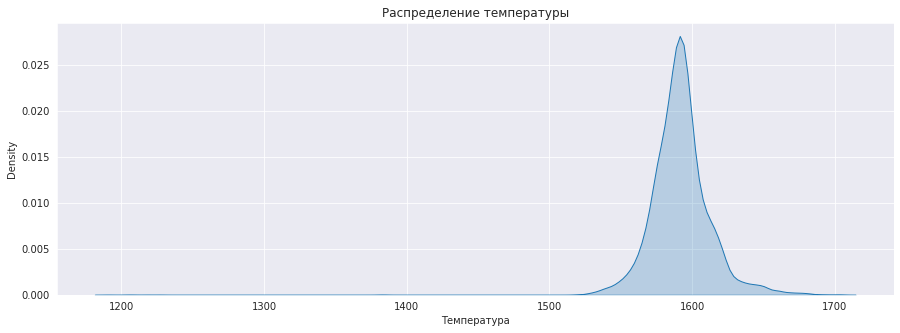

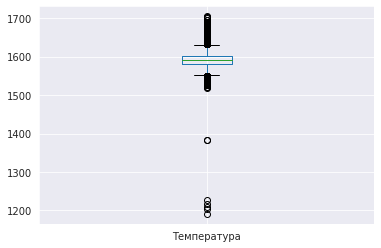

In [30]:
plt.figure(figsize=(15, 5))
fig = sns.kdeplot(df_temp['Температура'], legend=True,shade=True)
plt.title('Распределение температуры')
plt.show()
fig2 =df_temp.boxplot('Температура')

Тип данных приведены в нужный формат. Пропуски удалили, заменять нечем.

### Данные о проволочных материалах (объём)

In [31]:
fun_date(df_wire)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

-------------------------------------------------------------------------------------------------------------
Cтатистическиe данные


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


-------------------------------------------------------------------------------------------------------------
Вывод рандомных строк


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2642,2776,83.123039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1566,1645,103.100396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2454,2581,75.129601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------------------------------------------------------------------------------------------------------------
Количества дубликатов


0

-------------------------------------------------------------------------------------------------------------
Количества пропущеных значений


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

-------------------------------------------------------------------------------------------------------------


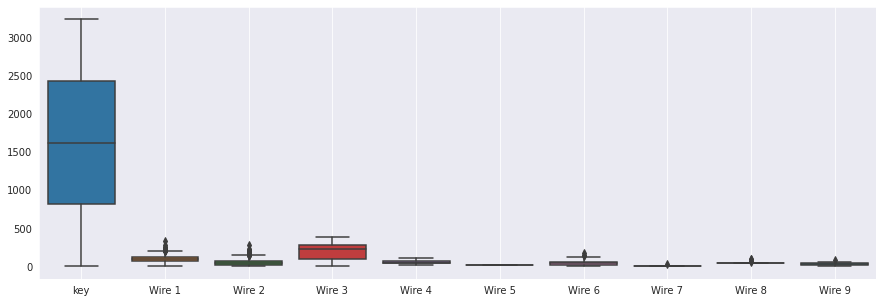

In [32]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_wire)
plt.grid();

Имеются пропуски. 

### Исследовательский анализ

Исследовать df_arc (данные об электродах) для определения целевого признака. В df_temp(результаты измерения температуры)  найдем начальные и конечные замеры. Объединить данные  в одну таблицу и определим целевой признак. 

In [33]:
df_arc_count = df_arc.groupby(by = 'key', as_index = False).count()[['key','Начало нагрева дугой']]
df_arc_count.columns = ['key','Количество итераций нагрева']


Определили количество итераций нагрева

In [34]:
df_arc = df_arc.groupby(by = 'key', as_index = False).sum()
df_arc = df_arc.merge(df_arc_count, how='left', on = 'key')

группировка по партиям

In [35]:
df_arc = df_arc.drop(columns = ['Активная мощность', 'Реактивная мощность'], axis = 1)

In [36]:
df_temp = df_temp.dropna(subset=['Температура']).reset_index(drop=True)
df_temp = df_temp.sort_values(by=['Время замера'])

count = df_temp.groupby(by = 'key', as_index=False).count()
one = count[count['Время замера']== 1]['key'].tolist()
df_temp = df_temp.query('key not in @one')

убрали пропуски в данных по замерам температуры, а также где имеется только один замер

In [37]:
df_temp = df_temp.groupby(by ='key').agg(['first', 'last']).reset_index()
df_temp.columns = df_temp.columns.droplevel()
df_temp.columns = ['key', 'Время замера 1', 'Время замера 2','Температура 1','Температура 2']
df_temp = df_temp[['key','Температура 1','Температура 2']]
df_temp

,key,Температура 1,Температура 2
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


группируем по первым и последним значениям замеры температуры

In [38]:
data = (df_temp.merge(df_arc, how='inner', on = 'key').merge(df_wire, how='inner', on = 'key').merge(df_bulk, how='inner', on = 'key').merge(df_gas, how='inner', on = 'key'))


In [39]:
data = data.fillna(0)
data.rename(columns={'Температура 1': 'Temp 1', 'Температура 2': 'Temp 2','Полная мощность': 'Full_pwr', 'Количество итераций нагрева': 'Count_iter'}, inplace=True)
data

,key,Temp 1,Temp 2,Full_pwr,Count_iter,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1
0,1,1571.0,1613.0,5.826395,5,60.059998,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986
1,2,1581.0,1602.0,3.649216,4,96.052315,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561
2,3,1596.0,1599.0,2.989534,5,91.160157,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793
3,4,1601.0,1625.0,3.814962,4,89.063515,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219
4,5,1576.0,1602.0,4.035758,4,89.238236,9.11456,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,3.986869,4,89.150879,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735
2325,2496,1554.0,1591.0,5.057033,6,114.179527,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616
2326,2497,1571.0,1589.0,2.885017,3,94.086723,9.04800,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699
2327,2498,1591.0,1594.0,4.143749,5,118.110717,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657


Объединили по inner, заодно  удалили строки где нет ни одной присадки или нет газа. 

Рассмотрим коррелирующие признаки

In [40]:
data.corr().unstack()[(data.corr().unstack() < 1) & (abs(data.corr().unstack()) > 0.7)]

Full_pwr    Count_iter    0.765932
Count_iter  Full_pwr      0.765932
Wire 4      Bulk 7        0.740572
Wire 8      Bulk 9        0.974969
Bulk 7      Wire 4        0.740572
Bulk 9      Wire 8        0.974969
dtype: float64

Высокая корреляция наблюдается между характеристиками электродов (количество обработок и длительность, реактивня, активная, общая мощность). Некоторые сыпучие и проволочные материалы вероятно используют чаще всего вместе и в коррелирующих пропорциях.
Посмотрим также на признаки сильнее всего коррелирующие с целевым признаком.

In [41]:
corr_target=pd.Series()
for col in data.columns:
    corr_target[col] = data['Temp 2'].corr(data[col])
corr_target= corr_target.sort_values(ascending=False)[1:]

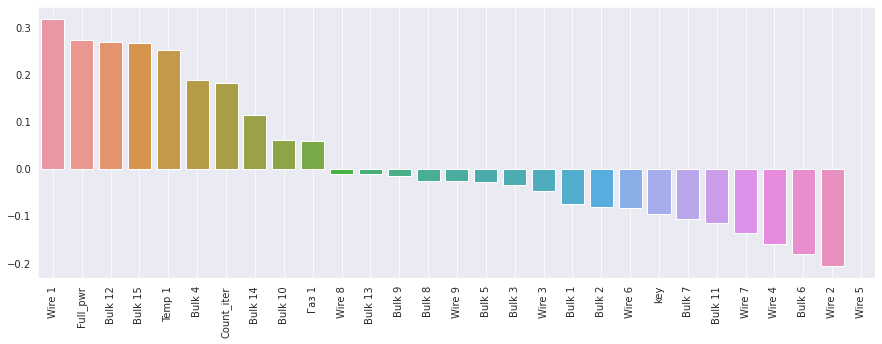

In [42]:
plt.figure(figsize=(15,5))
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.grid()
plt.xticks(rotation=90)
plt.show();

Факторов по отдельности сильно коррелирующих с таргетом нет, максимальная корреляция наблюдается в районе 0,3 с проволочным материалом 1; сыпучими материалами 12,15; начальной температурой и некоторыми характеристиками подготовки на этапе нагрева электродами

**Вывод**

* Определили количество итераций нагрева
* убрали ненужные данные
* определили начальный и конечный замер температуры
* объединили все в одну таблицу 
* целевой признак - конечная температура

## Обучение модели

* Разбить данные.
* Обучить несколько моделей и выбрать наиболее эффективную, при необходимости подобрать оптимальные гиперпараметры
* Провести обучение на тестовой выборке 
* Выбрать лучшую модель и сделать анализ

In [43]:
train, test = train_test_split(data, test_size=0.2, random_state=29082022)

In [44]:
train.columns

Index(['key', 'Temp 1', 'Temp 2', 'Full_pwr', 'Count_iter', 'Wire 1', 'Wire 2',
       'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9',
       'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7',
       'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13',
       'Bulk 14', 'Bulk 15', 'Газ 1'],
      dtype='object')

In [45]:
train_features = train.drop(['Temp 2','key'], axis =1)
train_target = train['Temp 2']

test_features = test.drop(['Temp 2','key'], axis =1)
test_target = test['Temp 2']

scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
print(len(train))
print(len(test))

1863
466


* Разбили на обучающую и тестовую выборку 70/20
* Целевой признак - вторая(конечная) температура
* Обучили скалер на тренировочной части данных, чтобы уменьшить переобучение

### Выбор моделей

In [46]:
result_list=[]
def hq (model):
    train_predict=model.predict(train_features)
    result_list.append({
        
        'train_mae_score': mean_absolute_error(train_target, train_predict)})    

In [47]:
model_CatBoost=CatBoostRegressor(random_seed=29082022)
model_CatBoost.fit(train_features, train_target)


Learning rate set to 0.045172
0:	learn: 11.2116946	total: 50.5ms	remaining: 50.5s
1:	learn: 11.0841675	total: 53.2ms	remaining: 26.5s
2:	learn: 10.9472233	total: 55.9ms	remaining: 18.6s
3:	learn: 10.8241404	total: 58.8ms	remaining: 14.6s
4:	learn: 10.7146062	total: 61.5ms	remaining: 12.2s
5:	learn: 10.6028500	total: 64.3ms	remaining: 10.7s
6:	learn: 10.5082558	total: 67.3ms	remaining: 9.55s
7:	learn: 10.4012076	total: 69.9ms	remaining: 8.67s
8:	learn: 10.3330632	total: 72.7ms	remaining: 8s
9:	learn: 10.2318652	total: 75.6ms	remaining: 7.48s
10:	learn: 10.1409899	total: 78.2ms	remaining: 7.03s
11:	learn: 10.0660388	total: 80.9ms	remaining: 6.66s
12:	learn: 9.9940605	total: 83.6ms	remaining: 6.34s
13:	learn: 9.9121914	total: 86.2ms	remaining: 6.07s
14:	learn: 9.8363722	total: 88.8ms	remaining: 5.83s
15:	learn: 9.7635913	total: 91.5ms	remaining: 5.63s
16:	learn: 9.6725004	total: 94.1ms	remaining: 5.44s
17:	learn: 9.6046782	total: 96.6ms	remaining: 5.27s
18:	learn: 9.5407583	total: 99.3ms	

In [48]:
model_LinearR = LinearRegression()
model_LinearR.fit(train_features, train_target)


LinearRegression()

In [49]:
model_LGBM = lgb.LGBMRegressor(random_state=29082022)
model_LGBM.fit(train_features, train_target)


LGBMRegressor(random_state=29082022)

In [50]:
hq(model_CatBoost)
hq(model_LGBM)
hq(model_LinearR)

In [51]:
result1 = pd.DataFrame(result_list, columns=['train_mae_score'], index=['model_CatBoost','model_LGBM','model_LinearR'])
result1

,train_mae_score
model_CatBoost,2.870341
model_LGBM,2.944028
model_LinearR,6.223085


Лучшая модель CatBoostRegressor

### Анализ модели CatBoost

In [52]:
train1, test1 = train_test_split(data, test_size=0.2, random_state=29082022)

In [53]:
train_features1 = train1.drop(['Temp 2','key'], axis =1)
train_target1 = train1['Temp 2']

test_features1 = test1.drop(['Temp 2','key'], axis =1)
test_target1 = test1['Temp 2']

In [54]:
model_CatBoost_test=CatBoostRegressor(random_seed=29082022)
model_CatBoost_test.fit(test_features1, test_target1)

Learning rate set to 0.03629
0:	learn: 10.5157866	total: 2.53ms	remaining: 2.53s
1:	learn: 10.4261433	total: 4.5ms	remaining: 2.25s
2:	learn: 10.3150076	total: 6.18ms	remaining: 2.06s
3:	learn: 10.2140570	total: 7.83ms	remaining: 1.95s
4:	learn: 10.1395699	total: 9.45ms	remaining: 1.88s
5:	learn: 10.0475300	total: 11.3ms	remaining: 1.87s
6:	learn: 9.9641628	total: 13ms	remaining: 1.84s
7:	learn: 9.8811881	total: 14.6ms	remaining: 1.82s
8:	learn: 9.8124583	total: 16.5ms	remaining: 1.81s
9:	learn: 9.7361611	total: 19ms	remaining: 1.88s
10:	learn: 9.6666510	total: 21.4ms	remaining: 1.93s
11:	learn: 9.5829274	total: 23ms	remaining: 1.9s
12:	learn: 9.5183070	total: 24.8ms	remaining: 1.88s
13:	learn: 9.4532948	total: 26.4ms	remaining: 1.86s
14:	learn: 9.4068638	total: 28.2ms	remaining: 1.85s
15:	learn: 9.3535991	total: 30.9ms	remaining: 1.9s
16:	learn: 9.2941547	total: 33.6ms	remaining: 1.94s
17:	learn: 9.2287978	total: 35.5ms	remaining: 1.93s
18:	learn: 9.1775736	total: 37.2ms	remaining: 1.

In [55]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=test_features1.columns).sort_values(ascending=False)
      
    fig, ax = plt.subplots(figsize=(12,8))
    feature_imp.plot.bar(ax=ax)
    _ = ax.set_title('Оценка важности признаков')
    _ = ax.set_ylabel('Признаки')
    fig.tight_layout()
   


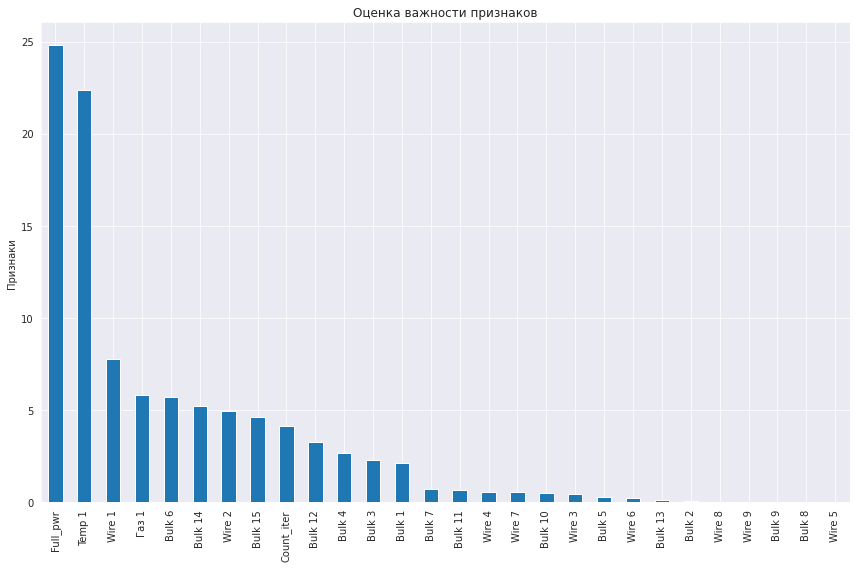

In [56]:
chart_feature_imp(model_CatBoost)

Важными параметрами являются:
* начальная температура и общая энергия.

In [57]:
test_predict=model_CatBoost.predict(test_features)
mae = mean_absolute_error(test_target, test_predict)
print('MAE на тестовой выборке=',mae)

MAE на тестовой выборке= 5.926926764222327


При финальном тестировании получили  МАЕ 5.92 на тестовой выборке.

## Вывод
* Провели предобработку и исследовательский анализ данных. 
* из трех моделей выбрали  CatBoost
* достигли MAE  с результатом 5.92

## Отчет о проделанной работе

Описание этапов исследования и полученные результаты.
1. Этап предобработки данных с исследовательским анализом данных.


Необходимо обратить внимание на следующие моменты по данному этапу:
*  приведение к типу datetime данных, содержащих дату и время технологического процесса.
*  убрать аномалии в реактивной мощности.
*  рассчитать корреляция между активом и реактивом. в нашем случае корреляция близка к единицe, значит  модель может переобучиться, будем использовать полную мощность.
* удалить пропуски в данных о подаче сыпучих материалов, т.к. заменить не чем.
* исследовать df_arc (данные об электродах) для определения целевого признака. 
*  df_temp(результаты измерения температуры) найдем начальные и конечные замеры. Объединить данные в одну таблицу и определить целевой признак.
* группировку по партиям.
* убрали пропуски в данных по замерам температуры, а также где имеется только один замер.
* группировка по первым и последним значениям замеры температуры. 
* соединение данных по ключу партии, тип связи - внутреннее соединение.

2. Этап обучение моделей.
* разбить на обучающую и тестовую выборку 70/20
* целевой признак - вторая(конечная) температура
* обучить  скалер на тренировочной части данных, для LinearRegression()
* обучение моделей на трейне без дополнительного подбора гиперпараметров дали следующие результаты **train_mae_score**:
           LinearRegression  - 6.223085
           CatBoostRegressor - 2.870341
           LGBMRegressor     - 2.944028
* выбрана модель CatBoostRegressor .

* оценка качества модели CatBoostRegressor на тестовой выборке MAE=5.92 
* модель CatBoostRegressor рекомендована к использованию для прогнозирования температуры стали
При проведении анализа с помощью feature_importances выяснил, что основные признаки:  **начальная температура и общая энергия**.


**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

Все пункты плана были выполнены. Не подбирал гиперпараметров, т.к. полученный положительный результат без подбора был длостигнут.  

**Какие трудности возникли и как вы их преодолели?**

Понимание технологического процесса обработки стали. Эту проблему я преодолел путем знакомства с процессом обработки. 


**Какие ключевые шаги в решении задачи выделили?**

Правильная предобработка и хороший исследовательский анализ данных главное в этой работе, которая позволит получить хорошие метрики.


**Какая ваша итоговая модель и какое у неё качество?**

CatBoostRegressor на тестовой выборке MAE=5.92 